# VisionMaskGuard: Mask Detection Model Training Notebook
This notebook trains a mask detection model using transfer learning with MobileNetV2 on the Face Mask Detection dataset.

**Steps Covered:**
1. Install dependencies
2. Clone and explore the dataset
3. Build and compile the model
4. Train with data augmentation
5. Plot training metrics
6. Save the trained model


In [1]:
# 1️⃣ Install required libraries
!pip install tensorflow keras opencv-python numpy imutils


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 2️⃣ Clone the Face Mask Detection repository (includes dataset and helper code)
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git

fatal: destination path 'Face-Mask-Detection' already exists and is not an empty directory.


In [3]:
# 3️⃣ Explore dataset structure and class counts
import os
dataset_dir = 'Face-Mask-Detection/dataset'
classes = os.listdir(dataset_dir)
counts = {c: len(os.listdir(os.path.join(dataset_dir, c))) for c in classes}
print('Classes and image counts:', counts)

Classes and image counts: {'without_mask': 1930, 'with_mask': 2165}


In [4]:
# 4️⃣ Build the model using MobileNetV2 transfer learning
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

# Model hyperparameters
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
IMAGE_SIZE = (224, 224)

# Data generators for augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training and validation generators
train_gen = aug.flow_from_directory(
    dataset_dir,
    target_size=IMAGE_SIZE,
    batch_size=BS,
    subset='training',
    class_mode='binary'
)
val_gen = aug.flow_from_directory(
    dataset_dir,
    target_size=IMAGE_SIZE,
    batch_size=BS,
    subset='validation',
    class_mode='binary'
)

# Load base model
baseModel = MobileNetV2(weights='imagenet', include_top=False,
                        input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

# Compile model
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Found 3274 images belonging to 2 classes.
Found 818 images belonging to 2 classes.


C:\Users\rahul\AppData\Local\Temp\ipykernel_10936\2548516144.py:44: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights='imagenet', include_top=False,
c:\Github\ai-mask-detector\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
!pip install pillow
!pip install scipy


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 41.2/41.2 MB 1.1 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import PIL
from PIL import Image
print("Pillow version:", PIL.__version__)


Pillow version: 11.2.1


In [9]:
# 5️⃣ Train the model
H = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BS,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BS,
    epochs=EPOCHS
)

Epoch 1/20


c:\Github\ai-mask-detector\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


 69/102 ━━━━━━━━━━━━━━━━━━━━ 1:06 2s/step - accuracy: 0.6517 - loss: 0.7551

c:\Github\ai-mask-detector\venv\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6987 - loss: 0.6615

c:\Github\ai-mask-detector\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.6998 - loss: 0.6592 - val_accuracy: 0.9675 - val_loss: 0.1533
Epoch 2/20
  1/102 ━━━━━━━━━━━━━━━━━━━━ 1:23 830ms/step - accuracy: 0.9375 - loss: 0.3281

c:\Github\ai-mask-detector\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 0.9375 - loss: 0.3281 - val_accuracy: 0.9638 - val_loss: 0.1691
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9569 - loss: 0.1523 - val_accuracy: 0.9725 - val_loss: 0.0943
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.9375 - loss: 0.1599 - val_accuracy: 0.9700 - val_loss: 0.0973
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1404s 14s/step - accuracy: 0.9579 - loss: 0.1226 - val_accuracy: 0.9725 - val_loss: 0.0848
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 336ms/step - accuracy: 0.8750 - loss: 0.1942 - val_accuracy: 0.9787 - val_loss: 0.0825
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1234s 12s/step - accuracy: 0.9653 - loss: 0.1004 - val_accuracy: 0.9762 - val_loss: 0.0710
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 391ms/step - accuracy: 0.9688 - loss: 0.0861 - val_accuracy: 0.9837 - val_loss: 0.0699
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 8916s 88s/step - accuracy: 0.9700 - loss: 0.0818 - val_a

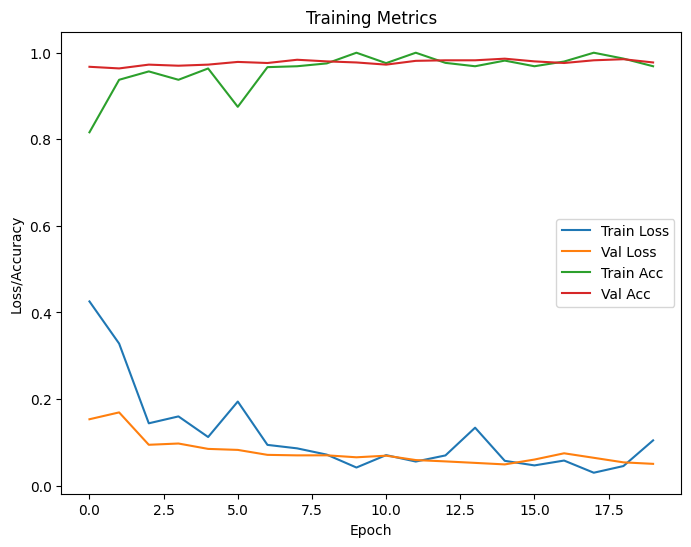

In [11]:
# 6️⃣ Plot training metrics
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(H.history['loss'], label='Train Loss')
plt.plot(H.history['val_loss'], label='Val Loss')
plt.plot(H.history['accuracy'], label='Train Acc')
plt.plot(H.history['val_accuracy'], label='Val Acc')
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [13]:
# 7️⃣ Save the trained model for real-time detection
model.save('mask_detector.h5')
print('✅ Model saved as mask_detector.model in current directory')

✅ Model saved as mask_detector.model in current directory
